In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn import metrics
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR


house_price = load_boston()
df = pd.DataFrame(house_price.data, columns=house_price.feature_names)
df['PRICE'] = house_price.target
df['const'] = 1
print(df.head(10))

# standardize and train/test split
house_price.data = preprocessing.scale(house_price.data)
X_train, X_test, y_train, y_test = train_test_split(
    house_price.data, house_price.target, test_size=0.3, random_state=10)

      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622  3.0  222.0   
5  0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622  3.0  222.0   
6  0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605  5.0  311.0   
7  0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8  0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821  5.0  311.0   
9  0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0  311.0   

   PTRATIO       B  LSTAT  PRICE  const  
0     15.3  396.90   4.98   24.0      1  
1     17.8  396.90   9.14   21.6      1  
2     17.8  392.83   4.03   34.7      1  
3     18.7  394.6

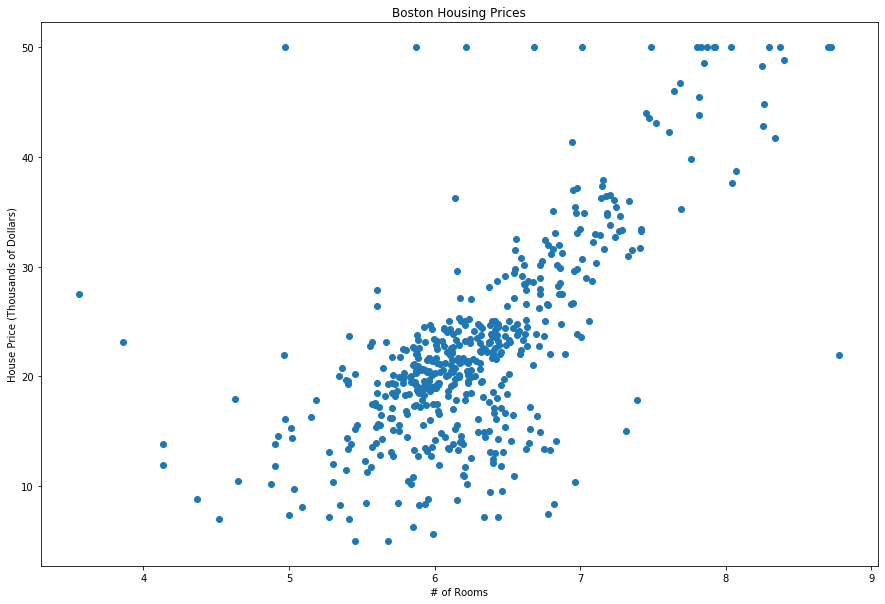

In [2]:
plt.figure(figsize=(15,10))
plt.scatter(x=df['RM'], y=df['PRICE'])
plt.xlabel('# of Rooms')
plt.ylabel('House Price (Thousands of Dollars)')
plt.title('Boston Housing Prices')
plt.show()

In [3]:
ols_reg = LinearRegression()
ols_reg.fit(X_train, y_train)
ols_pred = ols_reg.predict(X_test)

print(metrics.mean_absolute_error(y_test, ols_pred))
print(metrics.mean_squared_error(y_test, ols_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, ols_pred)))

3.7071271372718146
29.326596526123268
5.415403634644722


In [4]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'test',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    'max_depth': 8,
    'num_leaves': 128,  
    'max_bin': 512,
    'num_iterations': 100000,
    'n_estimators': 1000
}


print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)


lgbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

print(metrics.mean_absolute_error(y_test, lgbm_pred))
print(metrics.mean_squared_error(y_test, lgbm_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, lgbm_pred)))

Starting training...
[1]	valid_0's l2: 100.477	valid_0's l1: 7.14326
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 99.8322	valid_0's l1: 7.11724
[3]	valid_0's l2: 99.1922	valid_0's l1: 7.09118
[4]	valid_0's l2: 98.5597	valid_0's l1: 7.06554
[5]	valid_0's l2: 97.9332	valid_0's l1: 7.04043
[6]	valid_0's l2: 97.3124	valid_0's l1: 7.01558
[7]	valid_0's l2: 96.6973	valid_0's l1: 6.9906
[8]	valid_0's l2: 96.0957	valid_0's l1: 6.96601
[9]	valid_0's l2: 95.4717	valid_0's l1: 6.94026
[10]	valid_0's l2: 94.8662	valid_0's l1: 6.91559
[11]	valid_0's l2: 94.2828	valid_0's l1: 6.89225
[12]	valid_0's l2: 93.6874	valid_0's l1: 6.86819
[13]	valid_0's l2: 93.0963	valid_0's l1: 6.84415
[14]	valid_0's l2: 92.511	valid_0's l1: 6.82023
[15]	valid_0's l2: 91.9314	valid_0's l1: 6.79643
[16]	valid_0's l2: 91.3748	valid_0's l1: 6.77365
[17]	valid_0's l2: 90.8059	valid_0's l1: 6.75007
[18]	valid_0's l2: 90.2425	valid_0's l1: 6.72661
[19]	valid_0's l2: 89.704	valid_0's l1: 6.70454


C:\Users\Orsan\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[225]	valid_0's l2: 33.7371	valid_0's l1: 3.91312
[226]	valid_0's l2: 33.6304	valid_0's l1: 3.90574
[227]	valid_0's l2: 33.5245	valid_0's l1: 3.89839
[228]	valid_0's l2: 33.4168	valid_0's l1: 3.89061
[229]	valid_0's l2: 33.3111	valid_0's l1: 3.88304
[230]	valid_0's l2: 33.2092	valid_0's l1: 3.87558
[231]	valid_0's l2: 33.1047	valid_0's l1: 3.86851
[232]	valid_0's l2: 32.9955	valid_0's l1: 3.86116
[233]	valid_0's l2: 32.8886	valid_0's l1: 3.85322
[234]	valid_0's l2: 32.7811	valid_0's l1: 3.84537
[235]	valid_0's l2: 32.6748	valid_0's l1: 3.83756
[236]	valid_0's l2: 32.5709	valid_0's l1: 3.82973
[237]	valid_0's l2: 32.4666	valid_0's l1: 3.822
[238]	valid_0's l2: 32.3747	valid_0's l1: 3.81512
[239]	valid_0's l2: 32.2747	valid_0's l1: 3.80686
[240]	valid_0's l2: 32.1779	valid_0's l1: 3.80005
[241]	valid_0's l2: 32.0792	valid_0's l1: 3.7944
[242]	valid_0's l2: 31.9814	valid_0's l1: 3.78877
[243]	valid_0's l2: 31.8816	valid_0's l1: 3.78265
[244]	valid_0's l2: 31.7851	valid_0's l1: 3.77648
[2

[478]	valid_0's l2: 21.8894	valid_0's l1: 3.05582
[479]	valid_0's l2: 21.8758	valid_0's l1: 3.05425
[480]	valid_0's l2: 21.8555	valid_0's l1: 3.05242
[481]	valid_0's l2: 21.837	valid_0's l1: 3.05102
[482]	valid_0's l2: 21.8188	valid_0's l1: 3.04963
[483]	valid_0's l2: 21.8043	valid_0's l1: 3.04831
[484]	valid_0's l2: 21.7864	valid_0's l1: 3.04694
[485]	valid_0's l2: 21.7692	valid_0's l1: 3.04559
[486]	valid_0's l2: 21.7495	valid_0's l1: 3.04423
[487]	valid_0's l2: 21.7355	valid_0's l1: 3.04294
[488]	valid_0's l2: 21.7164	valid_0's l1: 3.04172
[489]	valid_0's l2: 21.699	valid_0's l1: 3.04038
[490]	valid_0's l2: 21.6832	valid_0's l1: 3.03901
[491]	valid_0's l2: 21.6635	valid_0's l1: 3.03789
[492]	valid_0's l2: 21.644	valid_0's l1: 3.03678
[493]	valid_0's l2: 21.6248	valid_0's l1: 3.03568
[494]	valid_0's l2: 21.6045	valid_0's l1: 3.03461
[495]	valid_0's l2: 21.5785	valid_0's l1: 3.03289
[496]	valid_0's l2: 21.5599	valid_0's l1: 3.03188
[497]	valid_0's l2: 21.5415	valid_0's l1: 3.03093
[49

[696]	valid_0's l2: 18.9635	valid_0's l1: 2.87056
[697]	valid_0's l2: 18.9574	valid_0's l1: 2.87004
[698]	valid_0's l2: 18.9514	valid_0's l1: 2.86953
[699]	valid_0's l2: 18.9504	valid_0's l1: 2.86924
[700]	valid_0's l2: 18.9424	valid_0's l1: 2.86863
[701]	valid_0's l2: 18.9399	valid_0's l1: 2.86822
[702]	valid_0's l2: 18.9377	valid_0's l1: 2.86784
[703]	valid_0's l2: 18.9355	valid_0's l1: 2.86745
[704]	valid_0's l2: 18.9335	valid_0's l1: 2.86707
[705]	valid_0's l2: 18.931	valid_0's l1: 2.86677
[706]	valid_0's l2: 18.9287	valid_0's l1: 2.86639
[707]	valid_0's l2: 18.9263	valid_0's l1: 2.86615
[708]	valid_0's l2: 18.9244	valid_0's l1: 2.86586
[709]	valid_0's l2: 18.922	valid_0's l1: 2.86563
[710]	valid_0's l2: 18.9199	valid_0's l1: 2.86535
[711]	valid_0's l2: 18.9087	valid_0's l1: 2.86516
[712]	valid_0's l2: 18.8971	valid_0's l1: 2.86482
[713]	valid_0's l2: 18.8851	valid_0's l1: 2.86457
[714]	valid_0's l2: 18.8735	valid_0's l1: 2.86441
[715]	valid_0's l2: 18.865	valid_0's l1: 2.86338
[71

In [5]:
eps = 5
svr = LinearSVR(epsilon=eps, C=0.01, fit_intercept=True)

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

20.448051191544604
516.1120969841288
22.71810064649175


In [6]:
eps = 3
svr = LinearSVR(epsilon=eps, C=1, fit_intercept=True)

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

3.587917491491127
31.20137254787038
5.585818878899528


In [7]:
eps = 3
svr = LinearSVR(epsilon=eps, C=10, fit_intercept=True)

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

3.573643109241584
29.328422046608022
5.415572180906467


C:\Users\Orsan\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [13]:
eps = 3
svr = LinearSVR(epsilon=eps, C=20, fit_intercept=True)

svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

3.60197841149544
29.344054040524792
5.41701523355111


C:\Users\Orsan\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
svr=SVR(kernel='linear', epsilon=eps, C=10)

svr.fit(X_train, y_train)
svr_pred=svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

3.5984295267758095
29.168676668301146
5.4008033354586376


In [20]:
svr=SVR(kernel='rbf', epsilon=0.25, degree=2)

svr.fit(X_train, y_train)
svr_pred=svr.predict(X_test)

print(metrics.mean_absolute_error(y_test, svr_pred))
print(metrics.mean_squared_error(y_test, svr_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))


3.849450594223255
41.3434070112477
6.429883903403521
